In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing (csv), data mining
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
%matplotlib inline

In [19]:
#Read data from csv
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

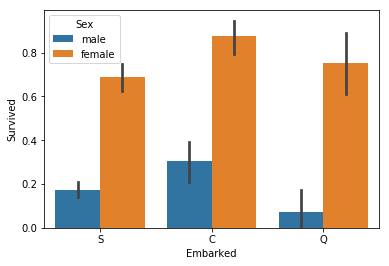

In [20]:
#Some visualizations :
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train)

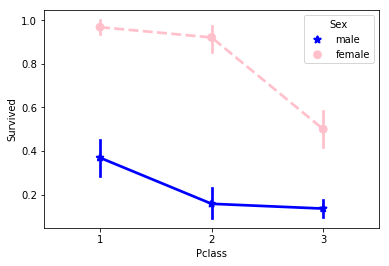

In [21]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"])
# here we notice that Pclass "1" is the best for surviving

In [22]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
# taking care of "age" feature
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5) #filling missing data
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

#"cabin" feature
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N') # filling missing values with "N"
    df.Cabin = df.Cabin.apply(lambda x: x[0]) # the first caracter is the most significant
    return df

# "fare" feature
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

# "name" feature:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
# drop unnecessary data    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

# combine changes
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df
#apply changes 
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


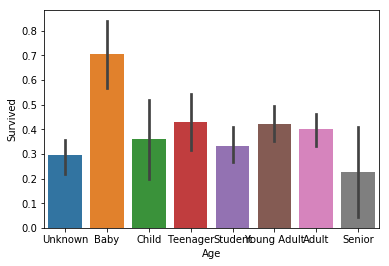

In [24]:
sns.barplot(x="Age", y="Survived", data=data_train)
#this is strange but baby category contains most of surviving people (maybe others sucrificed their lives for them)

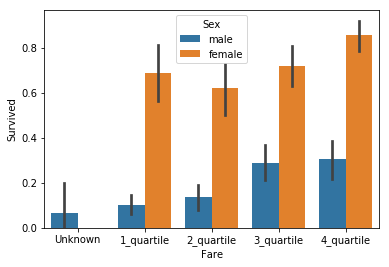

In [25]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train)

In [26]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]]) # we will work with these features
    
    for feature in features:
        le = preprocessing.LabelEncoder() #used to transform categorical data into numerical data
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [27]:
# Splitting data :
#Cross_validation
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived'] #target

num_test = 0.20 #20% are used as dev_set
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [28]:
# Classification and performance :
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))
X_test.head()

0.793296089385


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
727,3,0,6,0,0,0,7,488,16
668,3,1,0,0,0,1,7,168,19
210,3,1,4,0,0,0,7,14,19
654,3,0,5,0,0,0,7,328,16
228,2,1,5,0,0,1,7,243,19


In [30]:
pID = data_test.PassengerId
data_test = data_test.drop(['PassengerId'], axis=1)
data_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,3,1,7,0,0,0,7,401,19
1,3,0,0,1,0,0,7,843,20
2,2,1,3,0,0,1,7,552,19
3,3,1,7,0,0,1,7,851,19
4,3,0,4,1,1,1,7,342,20


In [31]:
validation_size = 0.20
seed = 7
#X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.20, random_state=23)

In [32]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

seed = 7
scoring = 'accuracy'

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RdmForest' , RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.792214 (0.048257)
LDA: 0.800626 (0.054553)
KNN: 0.571772 (0.054564)
CART: 0.776565 (0.054214)
NB: 0.772516 (0.048808)
SVM: 0.609624 (0.053856)
RdmForest: 0.803267 (0.039073)


In [59]:
#Make predictions using the features from the test data set

predictions = clf.predict(data_test)

#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Titanic Predictions 2.csv'

submission = pd.DataFrame({'PassengerId':pID,'Survived':predictions})
submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Titanic Predictions 2.csv
